Mounted at /content/drive


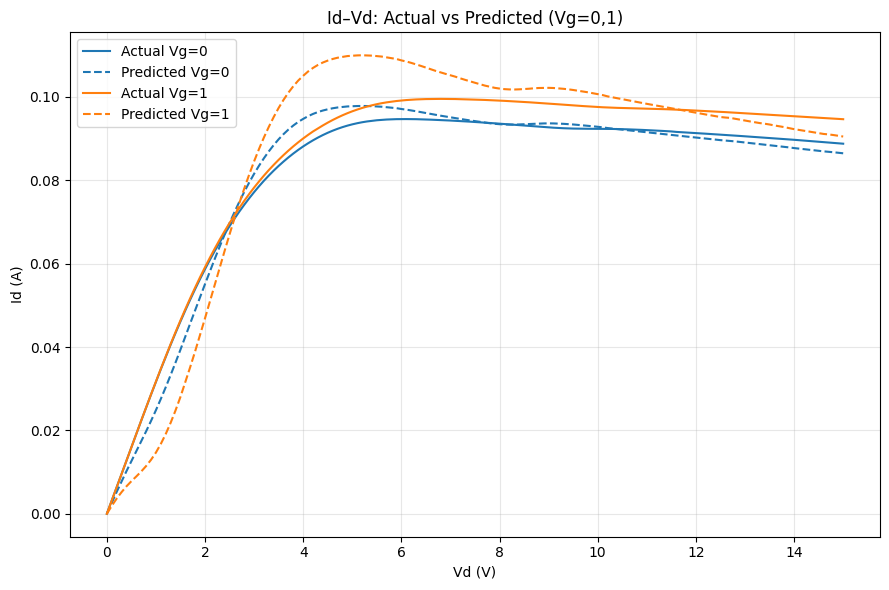

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from google.colab import drive


drive.mount('/content/drive')


file_path = '/content/drive/MyDrive/IdVd_D1_21_2.txt'

# 1) Load as a whitespace-delimited numeric matrix
# The file has 20 columns per row: left 10 for Id table (Vd + 9 Vg columns), right 10 for another block.
# Row 0 contains Vg headers for both blocks; column 0 is Vd values for data rows.
df_all = pd.read_csv(file_path, sep=r"\s+", header=None, engine="python")

# 2) Keep only the left 10 columns (Vd + Vg=-7..1), drop the rest
df_left = df_all.iloc[:, :10].copy()

# 3) Extract headers and data
#    - Row 0, columns 1..9 are Vg values [-7, -6, -5, -4, -3, -2, -1, 0, 1]
#    - Rows 1..end, column 0 is Vd
#    - Rows 1..end, columns 1..9 are Id for each Vg
vg_all = df_left.iloc[0, 1:].astype(float).to_numpy()       # length 9
vd = df_left.iloc[1:, 0].astype(float).to_numpy()           # length N
id_mat = df_left.iloc[1:, 1:].astype(float).to_numpy()      # shape (N, 9)

# 4) Build a tidy DataFrame with Vd as a column and Vg columns as floats
id_df = pd.DataFrame(id_mat, columns=vg_all)
id_df.insert(0, "Vd", vd)

# 5) Remove Vg = -7, -6 columns
drop_vg = [-7.0, -6.0]
keep_cols = ["Vd"] + [c for c in id_df.columns if (isinstance(c, (int, float)) and c not in drop_vg)]
id_df = id_df[keep_cols]

# 6) Define training and prediction Vg sets
train_vg = np.array([-5.0, -4.0, -3.0, -2.0, -1.0], dtype=float)
test_vg = np.array([0.0, 1.0], dtype=float)

# Sanity check that required columns exist
missing = [vg for vg in np.r_[train_vg, test_vg] if vg not in id_df.columns]
if len(missing) > 0:
    raise ValueError(f"Missing expected Vg columns in file: {missing}")

# 7) Fit per-Vd polynomial models Id(Vg) using only training Vg, then predict at Vg=0 and Vg=1
poly_deg = 2  # quadratic per-Vd fit; change to 1 for linear, or 3 if needed
y_train = id_df[train_vg].to_numpy()  # shape (N, 5)
pred_0 = np.empty(len(vd))
pred_1 = np.empty(len(vd))

for i in range(len(vd)):
    coeffs = np.polyfit(train_vg, y_train[i, :], deg=poly_deg)
    pred_0[i] = np.polyval(coeffs, 0.0)
    pred_1[i] = np.polyval(coeffs, 1.0)

# 8) Actual test traces at Vg=0 and Vg=1
act_0 = id_df[0.0].to_numpy()
act_1 = id_df[1.0].to_numpy()

# 9) Plot actual and predicted Id vs Vd for Vg=0 and Vg=1
plt.figure(figsize=(9, 6))
plt.plot(vd, act_0, label="Actual Vg=0", color="C0")
plt.plot(vd, pred_0, "--", label="Predicted Vg=0", color="C0")
plt.plot(vd, act_1, label="Actual Vg=1", color="C1")
plt.plot(vd, pred_1, "--", label="Predicted Vg=1", color="C1")
plt.xlabel("Vd (V)")
plt.ylabel("Id (A)")
plt.title("Id–Vd: Actual vs Predicted (Vg=0,1)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 10) (Optional) Save cleaned data and predictions
out = id_df.copy()
out["Pred_Id_Vg0"] = pred_0
out["Pred_Id_Vg1"] = pred_1
# out.to_csv("/content/drive/MyDrive/IdVd_clean_and_predictions.csv", index=False)


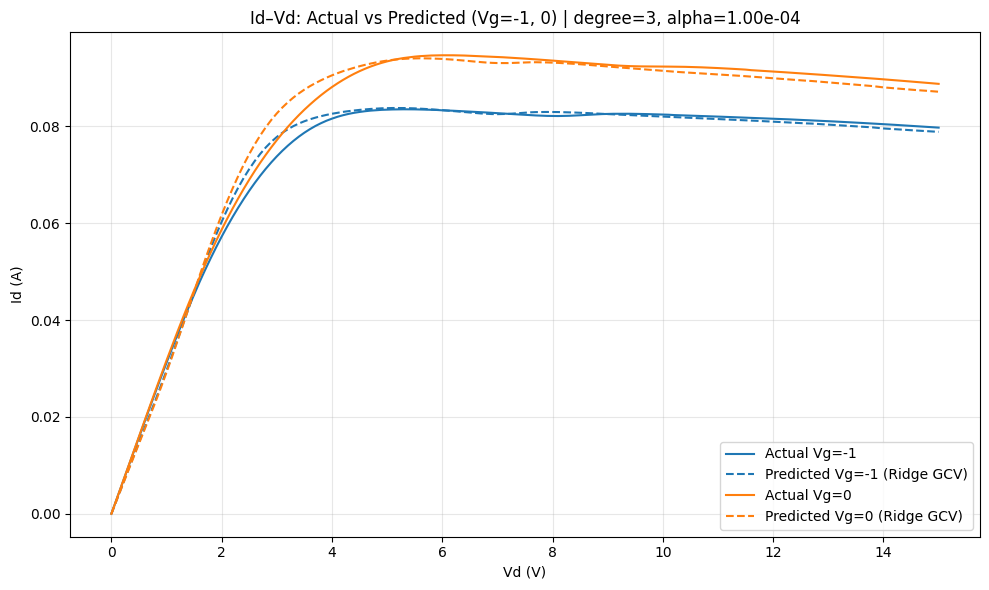

Chosen degree=3, alpha=1.00e-04, RMSE(Vg=-1)=1.440e-03, RMSE(Vg=0)=2.046e-03


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from google.colab import drive

# -----------------------------
# 1) Load and keep left 10 cols
# -----------------------------
df_all = pd.read_csv(file_path, sep=r"\s+", header=None, engine="python")
df_left = df_all.iloc[:, :10].copy()

# --------------------------------
# 2) Extract headers and data
#    Row 0: Vg headers in cols 1..9
#    Rows 1..: data; col 0 = Vd
# --------------------------------
vg_all = df_left.iloc[0, 1:].astype(float).to_numpy()       # Vg: [-7..1]
vd = df_left.iloc[1:, 0].astype(float).to_numpy()           # Vd values
id_mat = df_left.iloc[1:, 1:].astype(float).to_numpy()      # Id data

# ------------------------------------------------
# 3) Tidy frame with Vd + Vg columns (float keys)
#    Drop Vg = -7, -6 as requested
# ------------------------------------------------
id_df = pd.DataFrame(id_mat, columns=vg_all)
id_df.insert(0, "Vd", vd)
for vg_drop in [-7.0, -6.0]:
    if vg_drop in id_df.columns:
        id_df.drop(columns=[vg_drop], inplace=True)

# ------------------------------------------------
# 4) Define train/test gates and ensure availability
#    Train on {-5,-4,-3,-2,1,(2 if present)}, predict at {-1,0}
# ------------------------------------------------
test_vg = np.array([-1.0, 0.0], dtype=float)
requested_train = np.array([-5.0, -4.0, -3.0, -2.0, 1.0, 2.0], dtype=float)

available_vg = np.array([c for c in id_df.columns if c != "Vd"], dtype=float)
train_vg = np.array([g for g in requested_train if g in available_vg], dtype=float)

missing_tests = [g for g in test_vg if g not in id_df.columns]
if missing_tests:
    raise ValueError(f"Missing expected test Vg columns: {missing_tests}")
if len(train_vg) < 3:
    raise ValueError(f"Not enough training gates present; found {train_vg}")

# ----------------------------------------------
# 5) Build polynomial design and fast ridge GCV
#    - Intercept not penalized
#    - Select (degree, alpha) via GCV on subset
# ----------------------------------------------
def scale_to_unit_interval(x):
    x = np.asarray(x, dtype=float)
    xmin, xmax = x.min(), x.max()
    if xmax == xmin:
        return np.zeros_like(x), xmin, xmax
    z = 2.0 * (x - xmin) / (xmax - xmin) - 1.0
    return z, xmin, xmax

def poly_design(x, degree):
    x = np.asarray(x, dtype=float).reshape(-1)
    # columns: [1, x, x^2, ..., x^degree]
    Phi = np.column_stack([x**p for p in range(0, degree+1)])
    return Phi

# Prepare training matrix Y (rows: Vd grid, cols: train Vg)
Y_train = id_df[train_vg].to_numpy()  # shape (n_vd, k)
n_vd, k = Y_train.shape

# Scale Vg for conditioning
x_train_raw = train_vg.reshape(-1)
x_train_scaled, xmin, xmax = scale_to_unit_interval(x_train_raw)

# Test gates scaled with same transform
def apply_scale(x):
    if xmax == xmin:
        return np.zeros_like(np.asarray(x, dtype=float))
    return 2.0 * (np.asarray(x, dtype=float) - xmin) / (xmax - xmin) - 1.0

x_test_scaled = apply_scale(test_vg)

# Degree and alpha grids (small and fast)
degree_grid = [2, 3, 4]           # try moderate capacity
alpha_grid = np.logspace(-10, -1, 10)  # gentle to moderate regularization

# Subset of Vd rows for GCV (evenly spaced)
n_sub = int(min(n_vd, 128))
sub_idx = np.linspace(0, n_vd - 1, n_sub, dtype=int)
Y_sub = Y_train[sub_idx, :].T  # shape (k, n_sub) for matrix ops below

best_score = np.inf
best_degree, best_alpha = None, None

I_k = np.eye(k)

for deg in degree_grid:
    Phi_tr = poly_design(x_train_scaled, deg)  # (k, d)
    d = Phi_tr.shape[1]

    # Penalize all but intercept
    pen = np.zeros(d, dtype=float)
    pen[1:] = 1.0
    Pen = np.diag(pen)

    # Precompute for test
    Phi_te = poly_design(x_test_scaled, deg)   # (m_test=2, d)

    # Precompute parts independent of alpha
    PtP = Phi_tr.T @ Phi_tr          # (d, d)
    Pt = Phi_tr.T                    # (d, k)

    for alpha in alpha_grid:
        A = PtP + alpha * Pen        # (d, d)
        # Solve once to get K = A^{-1} Phi^T
        K = np.linalg.solve(A, Pt)   # (d, k)

        # Hat matrix and its trace
        S = Phi_tr @ K               # (k, k)
        trS = np.trace(S)

        # GCV on subset: ((|| (I - S) y ||^2 / k) / (1 - tr(S)/k)^2), averaged over columns
        R = (I_k - S) @ Y_sub        # (k, n_sub)
        rss_cols = np.sum(R * R, axis=0)  # length n_sub
        gcv_cols = (rss_cols / k) / (1.0 - trS / k)**2
        gcv_mean = float(np.mean(gcv_cols))

        if gcv_mean < best_score:
            best_score = gcv_mean
            best_degree = deg
            best_alpha = alpha

# ----------------------------------------------
# 6) Fit once with best (degree, alpha) and predict
#    Vectorized across all Vd rows
# ----------------------------------------------
Phi_tr = poly_design(x_train_scaled, best_degree)
d = Phi_tr.shape[1]
pen = np.zeros(d, dtype=float)
pen[1:] = 1.0
Pen = np.diag(pen)
PtP = Phi_tr.T @ Phi_tr
Pt = Phi_tr.T
A = PtP + best_alpha * Pen
K = np.linalg.solve(A, Pt)               # (d, k)
Phi_te = poly_design(x_test_scaled, best_degree)  # (2, d)
H_test = Phi_te @ K                      # (2, k)

# Y_pred for all Vd rows in one shot
# Y_train: (n_vd, k), H_test.T: (k, 2) -> (n_vd, 2)
Y_pred = Y_train @ H_test.T
pred_m1 = Y_pred[:, 0]
pred_0  = Y_pred[:, 1]

# ----------------------------------------------
# 7) Actual target traces and plotting
# ----------------------------------------------
act_m1 = id_df[-1.0].to_numpy()
act_0  = id_df[0.0].to_numpy()

plt.figure(figsize=(10, 6))
plt.plot(vd, act_m1, label="Actual Vg=-1", color="C0")
plt.plot(vd, pred_m1, "--", label="Predicted Vg=-1 (Ridge GCV)", color="C0")
plt.plot(vd, act_0, label="Actual Vg=0", color="C1")
plt.plot(vd, pred_0, "--", label="Predicted Vg=0 (Ridge GCV)", color="C1")
plt.xlabel("Vd (V)")
plt.ylabel("Id (A)")
plt.title(f"Id–Vd: Actual vs Predicted (Vg=-1, 0) | degree={best_degree}, alpha={best_alpha:.2e}")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: quick error metrics
rmse_m1 = np.sqrt(np.mean((act_m1 - pred_m1)**2))
rmse_0  = np.sqrt(np.mean((act_0  - pred_0 )**2))
print(f"Chosen degree={best_degree}, alpha={best_alpha:.2e}, RMSE(Vg=-1)={rmse_m1:.3e}, RMSE(Vg=0)={rmse_0:.3e}")


In [ ]:
# --- adjust paths if you don't want Drive ---
actual_path = "/content/drive/MyDrive/actual_values.txt"
pred_path   = "/content/drive/MyDrive/predicted_values.txt"

# --- vg order used in your script ---
vg_tests = [-1.0, 0.0]

# --- Build 2-column arrays (shape (N,2)) ---
actual_vals = np.column_stack([act_m1, act_0])   # columns: Vg=-1, Vg=0
pred_vals   = np.column_stack([pred_m1, pred_0])

# --- quick sanity checks ---
assert actual_vals.shape[0] == len(vd) and actual_vals.shape[1] == 2
assert pred_vals.shape[0] == len(vd) and pred_vals.shape[1] == 2

# --- writer (space-separated, no headers) ---
def write_plain_table(path, vd_arr, vals2d, vg_pair):
    with open(path, "w") as f:
        # first row: 0 <vg0> <vg1>
        f.write(f"0 {vg_pair[0]} {vg_pair[1]}\n")
        for i in range(len(vd_arr)):
            # use high-precision scientific format; change format if you prefer
            f.write("{:.12e} {:.12e} {:.12e}\n".format(vd_arr[i], vals2d[i,0], vals2d[i,1]))

# --- write files ---
write_plain_table(actual_path, vd, actual_vals, vg_tests)
write_plain_table(pred_path,   vd, pred_vals,   vg_tests)

print("Wrote:", actual_path)
print("Wrote:", pred_path)


Wrote: /content/drive/MyDrive/actual_values.txt
Wrote: /content/drive/MyDrive/predicted_values.txt


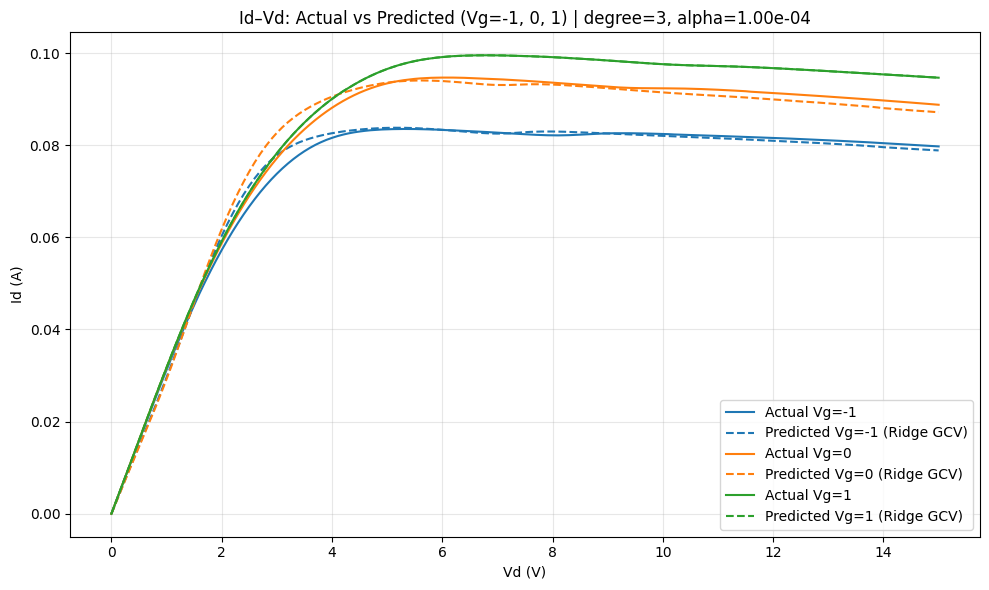

Chosen degree=3, alpha=1.00e-04, RMSE(Vg=-1)=1.440e-03, RMSE(Vg=0)=2.046e-03, RMSE(Vg=1)=8.351e-06


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from google.colab import drive

# -----------------------------
# 1) Load and keep left 10 cols
# -----------------------------
df_all = pd.read_csv(file_path, sep=r"\s+", header=None, engine="python")
df_left = df_all.iloc[:, :10].copy()

# --------------------------------
# 2) Extract headers and data
#    Row 0: Vg headers in cols 1..9
#    Rows 1..: data; col 0 = Vd
# --------------------------------
vg_all = df_left.iloc[0, 1:].astype(float).to_numpy()       # Vg: [-7..1]
vd = df_left.iloc[1:, 0].astype(float).to_numpy()           # Vd values
id_mat = df_left.iloc[1:, 1:].astype(float).to_numpy()      # Id data

# ------------------------------------------------
# 3) Tidy frame with Vd + Vg columns (float keys)
#    Drop Vg = -7, -6 as requested
# ------------------------------------------------
id_df = pd.DataFrame(id_mat, columns=vg_all)
id_df.insert(0, "Vd", vd)
for vg_drop in [-7.0, -6.0]:
    if vg_drop in id_df.columns:
        id_df.drop(columns=[vg_drop], inplace=True)

# ------------------------------------------------
# 4) Define train/test gates and ensure availability
#    Keep your training set as-is; predict at {-1, 0, 1}
# ------------------------------------------------
test_vg = np.array([-1.0, 0.0, 1.0], dtype=float)   # include +1 now
requested_train = np.array([-5.0, -4.0, -3.0, -2.0, 1.0, 2.0], dtype=float)

available_vg = np.array([c for c in id_df.columns if c != "Vd"], dtype=float)
train_vg = np.array([g for g in requested_train if g in available_vg], dtype=float)

missing_tests = [g for g in test_vg if g not in id_df.columns]
if missing_tests:
    raise ValueError(f"Missing expected test Vg columns: {missing_tests}")
if len(train_vg) < 3:
    raise ValueError(f"Not enough training gates present; found {train_vg}")

# ----------------------------------------------
# 5) Build polynomial design and fast ridge GCV
#    - Intercept not penalized
#    - Select (degree, alpha) via GCV on subset
# ----------------------------------------------
def scale_to_unit_interval(x):
    x = np.asarray(x, dtype=float)
    xmin, xmax = x.min(), x.max()
    if xmax == xmin:
        return np.zeros_like(x), xmin, xmax
    z = 2.0 * (x - xmin) / (xmax - xmin) - 1.0
    return z, xmin, xmax

def poly_design(x, degree):
    x = np.asarray(x, dtype=float).reshape(-1)
    Phi = np.column_stack([x**p for p in range(0, degree+1)])  # [1, x, x^2, ...]
    return Phi

# Prepare training matrix Y (rows: Vd grid, cols: train Vg)
Y_train = id_df[train_vg].to_numpy()  # shape (n_vd, k)
n_vd, k = Y_train.shape

# Scale Vg for conditioning
x_train_raw = train_vg.reshape(-1)
x_train_scaled, xmin, xmax = scale_to_unit_interval(x_train_raw)

# Test gates scaled with same transform (now 3 gates)
def apply_scale(x):
    if xmax == xmin:
        return np.zeros_like(np.asarray(x, dtype=float))
    return 2.0 * (np.asarray(x, dtype=float) - xmin) / (xmax - xmin) - 1.0

x_test_scaled = apply_scale(test_vg)

# Degree and alpha grids (small and fast)
degree_grid = [2, 3, 4]
alpha_grid = np.logspace(-10, -1, 10)

# Subset of Vd rows for GCV (evenly spaced)
n_sub = int(min(n_vd, 128))
sub_idx = np.linspace(0, n_vd - 1, n_sub, dtype=int)
Y_sub = Y_train[sub_idx, :].T  # shape (k, n_sub)

best_score = np.inf
best_degree, best_alpha = None, None

I_k = np.eye(k)

for deg in degree_grid:
    Phi_tr = poly_design(x_train_scaled, deg)  # (k, d)
    d = Phi_tr.shape[1]

    # Penalize all but intercept
    pen = np.zeros(d, dtype=float); pen[1:] = 1.0
    Pen = np.diag(pen)

    # Precompute for test
    Phi_te = poly_design(x_test_scaled, deg)   # (m_test=3, d)

    # Precompute parts independent of alpha
    PtP = Phi_tr.T @ Phi_tr
    Pt = Phi_tr.T

    for alpha in alpha_grid:
        A = PtP + alpha * Pen
        K = np.linalg.solve(A, Pt)            # (d, k)

        # Hat matrix and its trace
        S = Phi_tr @ K                        # (k, k)
        trS = np.trace(S)

        # GCV on subset
        R = (I_k - S) @ Y_sub                 # (k, n_sub)
        rss_cols = np.sum(R * R, axis=0)
        gcv_cols = (rss_cols / k) / (1.0 - trS / k)**2
        gcv_mean = float(np.mean(gcv_cols))

        if gcv_mean < best_score:
            best_score = gcv_mean
            best_degree = deg
            best_alpha = alpha

# ----------------------------------------------
# 6) Fit once with best (degree, alpha) and predict
#    Vectorized across all Vd rows
# ----------------------------------------------
Phi_tr = poly_design(x_train_scaled, best_degree)
d = Phi_tr.shape[1]
pen = np.zeros(d, dtype=float); pen[1:] = 1.0
Pen = np.diag(pen)
PtP = Phi_tr.T @ Phi_tr
Pt = Phi_tr.T
A = PtP + best_alpha * Pen
K = np.linalg.solve(A, Pt)                     # (d, k)
Phi_te = poly_design(x_test_scaled, best_degree)  # (3, d)
H_test = Phi_te @ K                            # (3, k)

# Y_pred for all Vd rows in one shot
# Y_train: (n_vd, k), H_test.T: (k, 3) -> (n_vd, 3)
Y_pred = Y_train @ H_test.T
pred_m1 = Y_pred[:, 0]
pred_0  = Y_pred[:, 1]
pred_p1 = Y_pred[:, 2]                         # new: Vg=+1 prediction

# ----------------------------------------------
# 7) Actual target traces and plotting
# ----------------------------------------------
act_m1 = id_df[-1.0].to_numpy()
act_0  = id_df[0.0].to_numpy()
act_p1 = id_df[1.0].to_numpy()

plt.figure(figsize=(10, 6))
plt.plot(vd, act_m1, label="Actual Vg=-1", color="C0")
plt.plot(vd, pred_m1, "--", label="Predicted Vg=-1 (Ridge GCV)", color="C0")
plt.plot(vd, act_0, label="Actual Vg=0", color="C1")
plt.plot(vd, pred_0, "--", label="Predicted Vg=0 (Ridge GCV)", color="C1")
plt.plot(vd, act_p1, label="Actual Vg=1", color="C2")
plt.plot(vd, pred_p1, "--", label="Predicted Vg=1 (Ridge GCV)", color="C2")
plt.xlabel("Vd (V)")
plt.ylabel("Id (A)")
plt.title(f"Id–Vd: Actual vs Predicted (Vg=-1, 0, 1) | degree={best_degree}, alpha={best_alpha:.2e}")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: quick error metrics
rmse_m1 = np.sqrt(np.mean((act_m1 - pred_m1)**2))
rmse_0  = np.sqrt(np.mean((act_0  - pred_0 )**2))
rmse_p1 = np.sqrt(np.mean((act_p1 - pred_p1)**2))
print(f"Chosen degree={best_degree}, alpha={best_alpha:.2e}, "
      f"RMSE(Vg=-1)={rmse_m1:.3e}, RMSE(Vg=0)={rmse_0:.3e}, RMSE(Vg=1)={rmse_p1:.3e}")


Selected model: krr_rbf  CV_RMSE=1.495965e-03  params={'krr__alpha': 1e-06, 'krr__gamma': 0.1}
Test Vg=-1: RMSE = 7.051317e-04
Test Vg= 0: RMSE = 9.518123e-04
Test Vg= 1: RMSE = 3.446569e-03


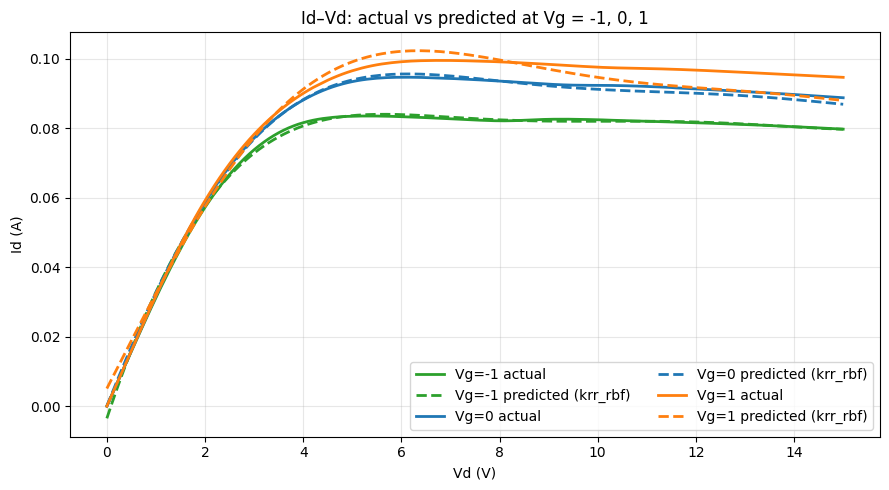

In [ ]:
# ... your data prep that builds Id, X_train, y_train, groups ...

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, GroupKFold
import numpy as np

# Emphasize gates near test (closest is Vg=-1) and small Vd for the left shoulder
vd_train = X_train[:, 0]
vg_train = X_train[:, 1]
w_vd = 0.7 + 0.3 * np.exp(-vd_train / 0.6)            # upweight small Vd
w_vg = 0.7 + 0.3 * np.exp(-np.abs(vg_train + 1.0))    # emphasize Vg=-1
sample_w = w_vd * w_vg

# Saturating Vd featurizer: small-Vd slope + smooth plateau
class SatFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, tau_list=(0.05, 0.1, 0.2, 0.5, 1.0, 2.0), vg_degree=2, include_vd_linear=True):
        self.tau_list = tuple(tau_list)
        self.vg_degree = int(vg_degree)
        self.include_vd_linear = bool(include_vd_linear)
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = np.asarray(X, dtype=float)
        vd = np.maximum(X[:, 0], 0.0)
        vg = X[:, 1]
        # Vg polynomial basis
        Phi_vg = [np.ones_like(vg)] + [vg**d for d in range(1, self.vg_degree + 1)]
        Phi_vg = np.stack(Phi_vg, axis=1)   # (n, m)
        feats = []
        if self.include_vd_linear:
            for j in range(Phi_vg.shape[1]):
                feats.append(vd * Phi_vg[:, j])
        for tau in self.tau_list:
            s = 1.0 - np.exp(-vd / float(tau))
            for j in range(Phi_vg.shape[1]):
                feats.append(s * Phi_vg[:, j])
                feats.append((s**2) * Phi_vg[:, j])
        return np.column_stack(feats)

# Candidates
cv = GroupKFold(n_splits=len(np.unique(groups)))

candidates = []

# Baseline poly+ridge
poly_ridge = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scaler", StandardScaler(with_mean=False)),
    ("ridge", Ridge(random_state=42))
])
candidates.append(("poly_ridge_d3", poly_ridge, {"ridge__alpha": [1e-6, 1e-4, 1e-2, 1e0]}))

# Saturating-basis ridge
sat_ridge = Pipeline([
    ("sat", SatFeaturizer()),
    ("scaler", StandardScaler(with_mean=False)),
    ("ridge", Ridge(random_state=42))
])
candidates.append(("sat_ridge", sat_ridge, {
    "sat__vg_degree": [1, 2],
    "sat__tau_list": [(0.02, 0.05, 0.1, 0.2, 0.5, 1.0), (0.05, 0.1, 0.2, 0.5, 1.0, 2.0)],
    "ridge__alpha": [1e-8, 1e-6, 1e-4, 1e-2]
}))

# Kernel Ridge (no weights in many versions) — leave unweighted
krr = Pipeline([
    ("scaler", StandardScaler()),
    ("krr", KernelRidge(kernel="rbf"))
])
candidates.append(("krr_rbf", krr, {"krr__alpha": [1e-6, 1e-4, 1e-2, 1e-1], "krr__gamma": [1e-2, 1e-1, 1, 10]}))

# Optional: XGBoost with monotonic constraint in Vd
use_xgb = False
try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        monotone_constraints="(1,0)",  # + in Vd, unconstrained in Vg
        tree_method="hist",
        n_estimators=600, subsample=0.9, colsample_bytree=0.9
    )
    candidates.append(("xgb_monotone", xgb, {
        "max_depth": [3, 4, 5],
        "learning_rate": [0.05, 0.1],
        "min_child_weight": [1, 5, 10],
        "reg_lambda": [0.0, 1.0, 5.0]
    }))
    use_xgb = True
except Exception:
    pass  # xgboost not installed

# Helper: route weights correctly
def fit_with_weights(gs, name):
    if isinstance(gs.estimator, Pipeline):
        steps = [s for s, _ in gs.estimator.steps]
        if "ridge" in steps:
            return {"ridge__sample_weight": sample_w}
        if "krr" in steps:
            # KernelRidge may not accept weights depending on version; skip to avoid errors
            return {}
        return {}
    else:
        if name == "xgb_monotone":
            return {"sample_weight": sample_w}
        return {}

# Grid search
results = []
best_model = None
best_name, best_params = None, None
best_score = -np.inf
for name, est, grid in candidates:
    gs = GridSearchCV(estimator=est, param_grid=grid, cv=cv, scoring="neg_root_mean_squared_error",
                      n_jobs=-1, refit=True, verbose=0)
    fit_params = fit_with_weights(gs, name)
    gs.fit(X_train, y_train, groups=groups, **fit_params)
    if gs.best_score_ > best_score:
        best_score, best_model, best_name, best_params = gs.best_score_, gs.best_estimator_, name, gs.best_params_

print(f"Selected model: {best_name}  CV_RMSE={-best_score:.6e}  params={best_params}")

# Evaluate and plot (unchanged)
# def predict_for_vg(model, Id_df, vg):
#     vd = Id_df.index.values
#     X = np.column_stack([vd, np.full_like(vd, vg, dtype=float)])
#     y_pred = model.predict(X)
#     y_true = Id_df[vg].values
#     return vd, y_true, y_pred
# for vg in [0, 1]:
#     vd, y_true, y_pred = predict_for_vg(best_model, Id, vg)
#     rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
#     print(f"Test Vg={vg}: RMSE={rmse:.6e}")

# import matplotlib.pyplot as plt
# plt.figure(figsize=(8,5))
# for vg, color in zip([0,1], ["C0","C1"]):
#     vd, y_true, y_pred = predict_for_vg(best_model, Id, vg)
#     plt.plot(vd, y_true, color=color, lw=2, label=f"Vg={vg} actual")
#     plt.plot(vd, y_pred, color=color, ls="--", lw=2, label=f"Vg={vg} predicted ({best_name})")
# plt.xlabel("Vd (V)"); plt.ylabel("Id (A)"); plt.title("Id vs Vd at Vg=0,1")
# plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def predict_for_vg(model, Id_df, vg):
    vd = Id_df.index.values
    X = np.column_stack([vd, np.full_like(vd, vg, dtype=float)])
    y_pred = model.predict(X)
    y_true = Id_df[vg].values if vg in Id_df.columns else None
    return vd, y_true, y_pred

# Evaluate for Vg = -1, 0, 1
eval_vgs = [-1, 0, 1]
for vg in eval_vgs:
    vd, y_true, y_pred = predict_for_vg(best_model, Id, vg)
    rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
    print(f"Test Vg={vg:>2}: RMSE = {rmse:.6e}")

# Plot all three gates with distinct colors/styles
colors = { -1: "C2", 0: "C0", 1: "C1" }
plt.figure(figsize=(9, 5))
for vg in eval_vgs:
    vd, y_true, y_pred = predict_for_vg(best_model, Id, vg)
    plt.plot(vd, y_true, color=colors[vg], lw=2.0, label=f"Vg={vg} actual")
    plt.plot(vd, y_pred, color=colors[vg], ls="--", lw=2.0, label=f"Vg={vg} predicted ({best_name})")
plt.xlabel("Vd (V)")
plt.ylabel("Id (A)")
plt.title("Id–Vd: actual vs predicted at Vg = -1, 0, 1")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()



/tmp/ipython-input-2610699916.py:164: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_vg = test_eval.groupby("Vg").apply(



Model selection (sorted by CV RMSE):
transform  degree  cv_rmse
 identity       4 0.002006
    asinh       4 0.002378
 identity       3 0.004380
    asinh       3 0.004802
 identity       2 0.007667
    asinh       2 0.007672
 identity       1 0.009972
    asinh       1 0.010602

Chosen model: transform=identity, degree=4
Test (Vg=0,1) Overall RMSE=9.713157e-03, R2=0.82634

Per-Vg metrics (Vg in {0,1}):
 Vg     RMSE       R2
  0 0.003507 0.975393
  1 0.013281 0.695567


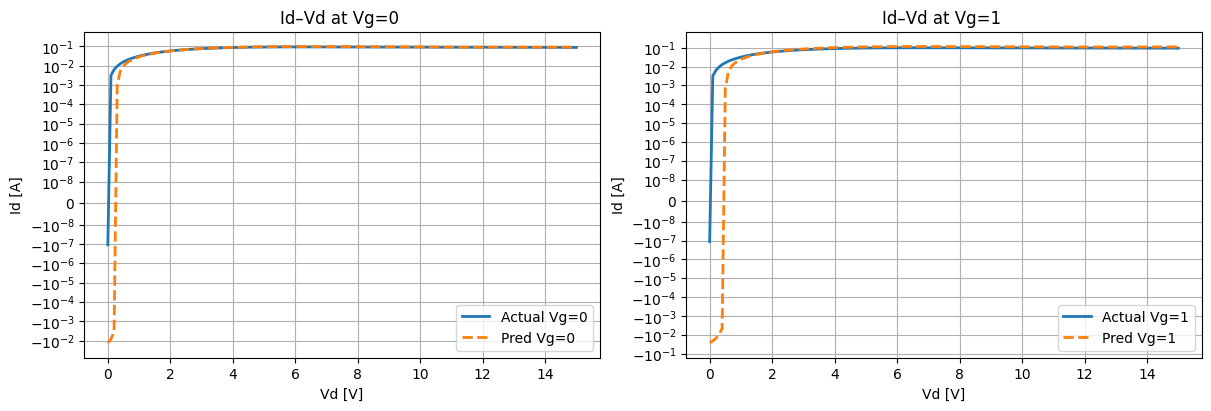

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Robust RMSE helper compatible with old/new scikit-learn
try:
    from sklearn.metrics import root_mean_squared_error as sk_rmse  # >=1.4
    def rmse(y_true, y_pred):
        return float(sk_rmse(y_true, y_pred))
except Exception:
    def rmse(y_true, y_pred):
        # For very old versions with no 'squared' argument
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# --------------------------
# 1) Load and parse the file
# --------------------------
FILE = file_path

# Use regex separator instead of deprecated delim_whitespace
df_raw = pd.read_csv(FILE, sep=r"\s+", header=None, engine="python")

# Keep only the left block: first 10 cols [Vd, Vg=-7..1]
# If the file has more columns, this trims the duplicate/right block.
if df_raw.shape[1] < 10:
    raise ValueError(f"Expected at least 10 columns, got {df_raw.shape[1]}.")
left = df_raw.iloc[:, :10].copy()

# The table format per your description:
# Row 0 has Vg headers across columns 1..9, Column 0 has Vd headers down rows.
# Row 0, Col 0 is redundant.
vg_header = left.iloc[0, 1:10].to_numpy()
# Expect integers -7..1 in order; if not exact ints due to formatting, round them.
vg_int = np.round(vg_header).astype(int)
expected = np.arange(-7, 2, 1)
if not np.array_equal(vg_int, expected):
    print("Warning: header Vg values not exactly [-7..1]; using detected rounded values:", vg_int)

cols = ["Vd"] + [f"Vg_{v}" for v in vg_int]
left.columns = cols + [f"extra_{i}" for i in range(left.shape[1] - len(cols))]  # safety if >10 cols

# Drop the header row and cast to float
left = left.drop(index=0).reset_index(drop=True).astype(float)

# Retain only Vd and the first 9 Vg columns (-7..1), then drop Vg=-7 and -6
keep_cols = ["Vd"] + [f"Vg_{v}" for v in vg_int]
left = left[keep_cols]

drop_vgs = {-7, -6}
keep_after_drop = ["Vd"] + [c for c in left.columns[1:] if int(c.split("_")[1]) not in drop_vgs]
df = left[keep_after_drop].copy()

# Ensure we have train Vg = -5..-1 and test Vg = 0..1
have_vgs = sorted(int(c.split("_")[1]) for c in df.columns[1:])
needed_train = set(range(-5, 0))
needed_test = {0, 1}
if not needed_train.issubset(have_vgs) or not needed_test.issubset(have_vgs):
    raise ValueError(f"Missing required Vg columns; have {have_vgs}, need train {-5,-1} and test {0,1}.")

# Melt to long format for regression over (Vd, Vg)
long_df = df.melt(id_vars="Vd", var_name="Vg_str", value_name="Id")
long_df["Vg"] = long_df["Vg_str"].str.replace("Vg_", "", regex=False).astype(int)
long_df = long_df.drop(columns=["Vg_str"])

# --------------------------
# 2) Split train/test by Vg
# --------------------------
train_df = long_df[long_df["Vg"].between(-5, -1)]
test_df  = long_df[long_df["Vg"].isin([0, 1])]

X_train = train_df[["Vd", "Vg"]].to_numpy()
y_train = train_df["Id"].to_numpy()

X_test  = test_df[["Vd", "Vg"]].to_numpy()
y_test  = test_df["Id"].to_numpy()

# --------------------------
# 3) Candidate models & CV
# --------------------------
degrees = [1, 2, 3, 4]
alphas = np.logspace(-6, 6, 13)
transforms = ["identity", "asinh"]

def fit_transform_y(y, tname, y0=None):
    if tname == "identity":
        return y, None
    elif tname == "asinh":
        # robust scale y0 from training targets
        if y0 is None:
            y_abs = np.abs(y)
            y0 = np.median(y_abs[y_abs > 0]) if np.any(y_abs > 0) else 1e-12
            y0 = max(y0, 1e-12)
        return np.arcsinh(y / y0), y0
    else:
        raise ValueError("Unknown transform")

def inverse_transform_y(y_tr, tname, y0):
    if tname == "identity":
        return y_tr
    elif tname == "asinh":
        return y0 * np.sinh(y_tr)
    else:
        raise ValueError("Unknown transform")

def make_pipeline(degree):
    # Omit deprecated store_cv_values/store_cv_results to avoid warnings; default False
    return Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("ridge", RidgeCV(alphas=alphas, fit_intercept=True))
    ])

kf = KFold(n_splits=5, shuffle=True, random_state=0)
results = []

for tname in transforms:
    y_tr_full, y0 = fit_transform_y(y_train, tname)
    for deg in degrees:
        pipe = make_pipeline(deg)
        fold_rmses = []
        for train_idx, val_idx in kf.split(X_train):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr = y_tr_full[train_idx]
            pipe.fit(X_tr, y_tr)
            y_pred_tr = pipe.predict(X_val)
            y_pred = inverse_transform_y(y_pred_tr, tname, y0)
            fold_rmses.append(rmse(y_train[val_idx], y_pred))
        mean_rmse = float(np.mean(fold_rmses))
        results.append({"transform": tname, "degree": deg, "cv_rmse": mean_rmse})

res_df = pd.DataFrame(results).sort_values(["cv_rmse", "transform", "degree"])
best = res_df.iloc[0].to_dict()
best_transform = best["transform"]
best_degree = int(best["degree"])

# --------------------------
# 4) Refit best model
# --------------------------
y_tr_full, y0 = fit_transform_y(y_train, best_transform)
best_model = make_pipeline(best_degree)
best_model.fit(X_train, y_tr_full)

# Predict on test Vg = 0 and 1
y_pred_tr = best_model.predict(X_test)
y_pred = inverse_transform_y(y_pred_tr, best_transform, y0)

# Evaluate overall and per Vg
overall_rmse = rmse(y_test, y_pred)
overall_r2   = r2_score(y_test, y_pred)

test_eval = pd.DataFrame({
    "Vd": X_test[:, 0],
    "Vg": X_test[:, 1].astype(int),
    "Id_true": y_test,
    "Id_pred": y_pred
})

per_vg = test_eval.groupby("Vg").apply(
    lambda g: pd.Series({
        "RMSE": rmse(g["Id_true"].to_numpy(), g["Id_pred"].to_numpy()),
        "R2": r2_score(g["Id_true"].to_numpy(), g["Id_pred"].to_numpy())
    })
).reset_index()

print("\nModel selection (sorted by CV RMSE):")
print(res_df.to_string(index=False))

print(f"\nChosen model: transform={best_transform}, degree={best_degree}")
print(f"Test (Vg=0,1) Overall RMSE={overall_rmse:.6e}, R2={overall_r2:.5f}\n")
print("Per-Vg metrics (Vg in {0,1}):")
print(per_vg.to_string(index=False))

# Save evaluation as CSV for record
res_df.to_csv("model_cv_results.csv", index=False)
test_eval.to_csv("pred_vs_true_Vg0_1.csv", index=False)
per_vg.to_csv("metrics_per_Vg.csv", index=False)

# --------------------------
# 5) Plot actual vs predicted
# --------------------------
def plot_slice(vg_val, ax, title_suffix=""):
    g = test_eval[test_eval["Vg"] == vg_val].sort_values("Vd")
    ax.plot(g["Vd"], g["Id_true"], label=f"Actual Vg={vg_val}", lw=2)
    ax.plot(g["Vd"], g["Id_pred"], "--", label=f"Pred Vg={vg_val}", lw=2)
    ax.set_xlabel("Vd [V]")
    ax.set_ylabel("Id [A]")
    ax.set_title(f"Id–Vd at Vg={vg_val} {title_suffix}")
    ax.grid(True)
    ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
plot_slice(0, axes[0])
plot_slice(1, axes[1])

# Use symlog to show small-signal and large currents together while preserving sign
for ax in axes:
    ax.set_yscale("symlog", linthresh=1e-8)

plt.show()


Chosen deg=2, p0=1.5, CV_RMSE=3.285315e-03
Test RMSE=3.260362e-02


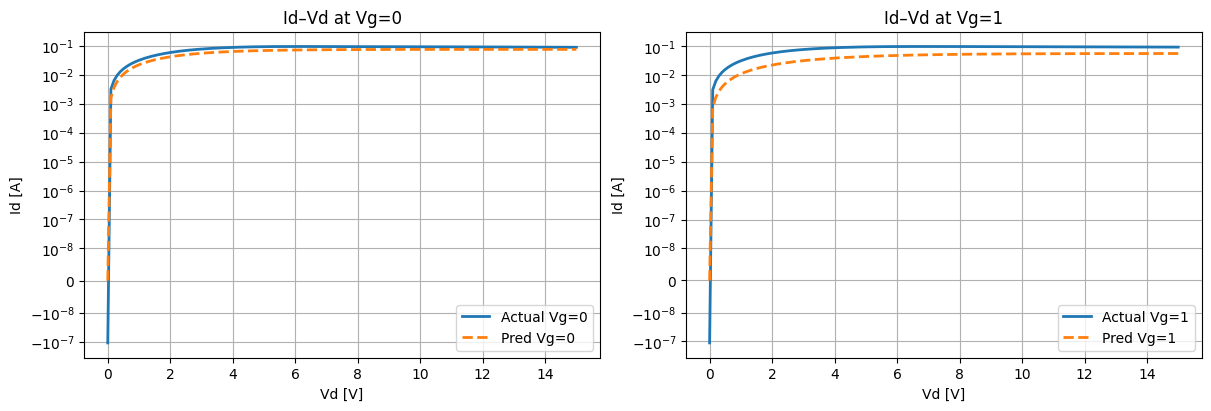

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from sklearn.model_selection import KFold

# ---------- load and reshape (same as before) ----------
FILE = file_path
df_raw = pd.read_csv(FILE, sep=r"\s+", header=None, engine="python")
left = df_raw.iloc[:, :10].copy()
vg_header = np.round(left.iloc[0, 1:10].to_numpy()).astype(int)
left.columns = ["Vd"] + [f"Vg_{v}" for v in vg_header]
left = left.drop(index=0).reset_index(drop=True).astype(float)

# drop Vg=-7,-6; train on -5..-1, test on 0..1
drop_vgs = {-7, -6}
keep_cols = ["Vd"] + [c for c in left.columns[1:] if int(c.split("_")[1]) not in drop_vgs]
df = left[keep_cols].copy()
long_df = df.melt(id_vars="Vd", var_name="Vg_str", value_name="Id")
long_df["Vg"] = long_df["Vg_str"].str.replace("Vg_", "", regex=False).astype(int)
long_df = long_df.drop(columns=["Vg_str"])

train_df = long_df[long_df["Vg"].between(-5, -1)].copy()
test_df  = long_df[long_df["Vg"].isin([0, 1])].copy()
X_train = train_df[["Vd", "Vg"]].to_numpy(); y_train = train_df["Id"].to_numpy()
X_test  = test_df[["Vd", "Vg"]].to_numpy();   y_test  = test_df["Id"].to_numpy()

# ---------- constrained saturating model ----------
def poly_basis(vg, deg):
    return np.stack([vg**d for d in range(deg+1)], axis=-1)

def unpack_params(theta, deg):
    m = deg + 1
    a = theta[:m]; b = theta[m:2*m]; p_raw = theta[-1]
    return a, b, p_raw

def predict_id(theta, vd, vg, deg):
    a, b, p_raw = unpack_params(theta, deg)
    phi = poly_basis(vg, deg)
    Isat = np.exp(phi @ a)
    Vc   = np.exp(phi @ b)
    p    = np.exp(p_raw)
    x = np.maximum(vd, 0.0) / (Vc + 1e-20)
    return Isat * (1.0 - np.exp(-np.power(x, p)))

# asinh-residuals (finite for any real y), with small-Vd emphasis and downweight negatives
def make_residual_fn(deg, y0, w_small_vd=2.0):
    def residuals(theta, vd, vg, y):
        yhat = predict_id(theta, vd, vg, deg)
        r = np.arcsinh(y / y0) - np.arcsinh(yhat / y0)
        w = np.ones_like(r)
        w[vd <= np.percentile(vd, 20)] *= w_small_vd
        w[y < 0] *= 0.5
        return w * r
    return residuals

def fit_once(vd, vg, y, deg, p_init=1.5):
    eps = 1e-15
    vg_u = np.sort(np.unique(vg))
    # init Isat and Vc per-Vg
    isat0 = []; vc0 = []
    for v in vg_u:
        m = vg == v
        vd_g = vd[m]; y_g = y[m]
        y_max = max(float(np.max(y_g)), eps)
        isat0.append(y_max)
        target = 0.632 * y_max
        idx = np.argmin(np.abs(y_g - target))
        vc0.append(max(vd_g[idx], 1e-6))
    Phi = poly_basis(vg_u, deg)
    a0 = np.linalg.lstsq(Phi, np.log(np.array(isat0) + eps), rcond=None)[0]
    b0 = np.linalg.lstsq(Phi, np.log(np.array(vc0) + eps), rcond=None)[0]
    theta0 = np.concatenate([a0, b0, [np.log(max(p_init, 0.1))]])

    # robust scale for asinh
    y0 = np.median(np.abs(y[y != 0])) if np.any(y != 0) else 1e-9
    y0 = max(y0, 1e-12)

    res = least_squares(
        make_residual_fn(deg, y0),
        theta0,
        args=(vd, vg, y),
        loss="soft_l1", f_scale=1.0, max_nfev=4000, verbose=0
    )
    return res.x, res

def kfold_cv(vd, vg, y, deg_grid=(1,2), p_inits=(1.0,1.5,2.0), splits=5, seed=0):
    kf = KFold(n_splits=splits, shuffle=True, random_state=seed)
    best = None
    for deg in deg_grid:
        for p0 in p_inits:
            rmses = []
            for tr, va in kf.split(vd):
                th, _ = fit_once(vd[tr], vg[tr], y[tr], deg, p_init=p0)
                yhat = predict_id(th, vd[va], vg[va], deg)
                rmses.append(float(np.sqrt(np.mean((y[va] - yhat)**2))))
            mr = float(np.mean(rmses))
            if (best is None) or (mr < best["cv_rmse"]):
                best = {"deg": deg, "p_init": p0, "cv_rmse": mr}
    return best

# ---------- fit + evaluate ----------
vd_tr, vg_tr, y_tr = X_train[:,0], X_train[:,1], y_train
sel = kfold_cv(vd_tr, vg_tr, y_tr, deg_grid=(1,2), p_inits=(1.0,1.5,2.0), splits=5, seed=0)
theta, _ = fit_once(vd_tr, vg_tr, y_tr, sel["deg"], p_init=sel["p_init"])

vd_te, vg_te, y_te = X_test[:,0], X_test[:,1], y_test
y_pred = predict_id(theta, vd_te, vg_te, sel["deg"])
print(f"Chosen deg={sel['deg']}, p0={sel['p_init']}, CV_RMSE={sel['cv_rmse']:.6e}")
print(f"Test RMSE={float(np.sqrt(np.mean((y_te - y_pred)**2))):.6e}")

# ---------- plots ----------
def plot_slice(vg_val, ax):
    m = vg_te == vg_val
    idx = np.argsort(vd_te[m])
    ax.plot(vd_te[m][idx], y_te[m][idx], label=f"Actual Vg={vg_val}", lw=2)
    ax.plot(vd_te[m][idx], y_pred[m][idx], "--", label=f"Pred Vg={vg_val}", lw=2)
    ax.set_xlabel("Vd [V]"); ax.set_ylabel("Id [A]")
    ax.set_title(f"Id–Vd at Vg={vg_val}")
    ax.set_yscale("symlog", linthresh=1e-8)
    ax.grid(True); ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
plot_slice(0, axes[0]); plot_slice(1, axes[1])
plt.show()
